## Road signs classifier

**Artur Skowroński 411423**\
**Szymon Socha [no_index]**

The aim of our project, is to create the most optimal model possible that can recognise individual road signs.
To do this, we used the publicly available dataset [GTSRB - German Traffic Sign Recognition Benchmark](https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign) containing more than 50,000 images of 43 traffic signs.
In order to test which of the algorithms for the image classification problem works best, we decided to use the following algorithms:
- RandomForest
- LightGBM (we are aware that we discussed another boosting model in class - XGBoost, however this one is definitely faster)
- Convolutional Neural Networks

Due to the fact that the dataset we have chosen is quite large and, in addition, we will be using neural networks, we have decided that we will use the resources of Google Drive, to which we can directly download images from Kaggle, and Google Colab, which will help us with faster calculations, without burdening the local machine.

With this in mind, we also include [instruction](https://medium.com/analytics-vidhya/how-to-download-kaggle-datasets-into-google-colab-via-google-drive-dcb348d7af07) on how to directly link a Google Drive account to a Kaggle account for our work.


**NOTE** DODAĆ DATA AUGMENTATION BO DATASET JEST NIEZBALANSOWANY

#### 1. Import libraries

In [17]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support
np.random.seed(42)

from matplotlib import style
style.use('fivethirtyeight')

In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
os.chdir("/content/drive/MyDrive/road-signs-NN")

In [ ]:
# import os
# os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/road-signs-NN"

In [ ]:
# %cd /content/drive/MyDrive/road-signs-NN

/content/drive/MyDrive/road-signs-NN


In [ ]:
# !kaggle datasets download -d meowmeowmeowmeowmeow/gtsrb-german-traffic-sign --unzip

 99% 606M/612M [00:04<00:00, 160MB/s]
100% 612M/612M [00:04<00:00, 157MB/s]


In [ ]:
# %ls

kaggle.json  Meta/     test/  Test.csv  Train/     Untitled0.ipynb
meta/        Meta.csv  Test/  train/    Train.csv


**Setting parameters**

In [21]:
# Paths
train_path = '/content/drive/MyDrive/road-signs-NN/Train'
test_path = '/content/drive/MyDrive/road-signs-NN/Test'
meta_path = '/content/drive/MyDrive/road-signs-NN/Meta'

# Resizing the images to 32x32x1
IMG_HEIGHT = 32
IMG_WIDTH = 32

# Total number of categories
NUM_CATEGORIES = len(os.listdir(train_path))
print(f'Dataset containts {NUM_CATEGORIES} different road signs.')

Dataset containts 43 different road signs.


Below, we will name our each road sign.

In [5]:
# Label Overview
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

In order to understand the distribution of the data, we have two helpful datasets in csv files.
Let's see how many pictures do we have in our datasets.

In [22]:
train_tabular = pd.read_csv('Train.csv')
test_tabular = pd.read_csv('Test.csv')

In [23]:
train_tabular.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png


In [24]:
train_df_desc = train_tabular.Path.apply(lambda x: x.split("/")[1])\
                             .value_counts()\
                             .to_frame()\
                             .reset_index()\
                             .rename({"index": "Index", "Path": "Cnt"}, axis=1)

train_df_desc["Class"] = pd.Series(classes)
train_df_desc["Index"].astype("int32")
train_df_desc["Index"].dtypes

dtype('O')

Ok, so we see that the highest number of signs is connected with speed limit signs.
Below we decided to show, two different signs. In the first case, the sign is quite obvious, so we assume, that our algorithm should not hvae any problem in recognising it. 
However, in the second example, on the first glance, it might be hard to estimate was sign is that.

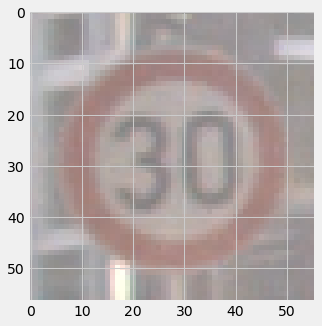

In [25]:
plt.figure(figsize=(10,5))
pic = Image.open(f'{train_path}/1/00001_00000_00000.png').convert('RGB')
plt.imshow(pic)

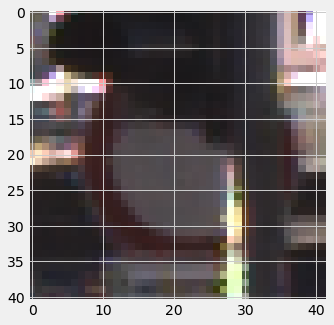

In [26]:
plt.figure(figsize=(10,5))
pic = Image.open(f'{train_path}/15/00015_00000_00000.png').convert('RGB')
plt.imshow(pic)

We see, that there are many different signs. Some are quite obvious, but other are even hard for human to recognise.

#### Data preparation

In [27]:
train_df_desc[train_df_desc.Index == str(1)]["Cnt"]

1    2220
Name: Cnt, dtype: int64

Images will be rescaled to 32x32 resolution, all transformed to grayscale (single channel image).

In [28]:
# Retrieving the images and their labels 

images_list = []
labels = []

for i in range(NUM_CATEGORIES):
    path = os.path.join(train_path, str(i))
    images = os.listdir(path)

    for no_image in images:
        try:
            pic = Image.open(path + '/'+ no_image).convert('L')
            image = pic.resize((IMG_WIDTH, IMG_HEIGHT), Image.ANTIALIAS)
            pixels = np.array(image)
            image_ravel = pixels.ravel()
            images_list.append(image_ravel)
            labels.append(i)
        except:
            print("Error loading image")

    # Maximum number of same signs can't be higher than 2250      
    # if len(image_list) < 2250:
    #     print(f"Number of pictures of sign {no_image} is equal to = {train_df_desc[train_df_desc.Index == str({1})]["Cnt"]} which is correct")
    # else:
    #     print(f"Something is wrong with the {no_image} image")

# Converting lists into numpy arrays
images_list = np.array(images_list)
labels = np.array(labels)

In [29]:
# Check if everything is OK
print(images_list.shape, labels.shape)

(39209, 1024) (39209,)


#### Spliting into train/test

In [10]:
# Splitting training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(images_list, labels, test_size=0.2, random_state=42)

# Displaying the shape after the split
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# Converting the labels into one hot encoding
# y_train = to_categorical(y_train, 43)
# y_test = to_categorical(y_test, 43)

(31367, 1024) (7842, 1024) (31367,) (7842,)


#### Frequency distribution

In [ ]:
# train_distribution = pd.crosstab(index=train["label"],
#                                  columns="count")

# test_distribution = pd.crosstab(index=test["label"],
#                                 columns="count")

# fig, ax = plt.subplots(1,2, figsize=(15,7))
# train_distribution.plot.bar(ax=ax[0], title='Train', legend=False, cmap='PuBuGn_r')
# test_distribution.plot.bar(ax=ax[1], title='Test', legend=False)
# fig.show()


#### Preview the images



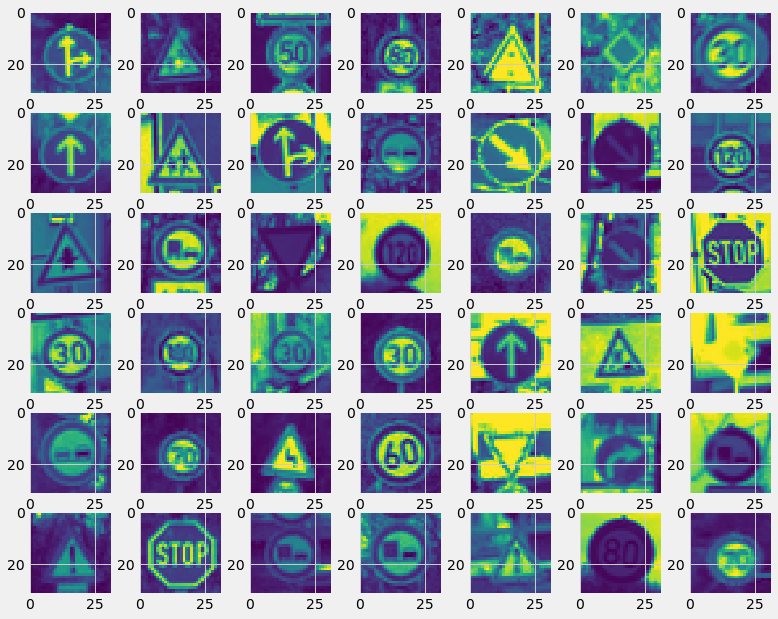

In [11]:
plt.figure(figsize=(12,10))
x, y = 7, 6
for i in range(42):  
    plt.subplot(y, x, i+1)
    plt.imshow(X_train[i].reshape((IMG_WIDTH, IMG_HEIGHT)), interpolation='nearest')
plt.show()

Successfully achieved 1 channel

#### Additional preparations

In [30]:
# Normalization to values between 0 an 1

X_train = X_train/255.0
X_test = X_test/255.0

In [31]:
# checking if all dimensions are correct

print('x_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

x_train shape: (31367, 1024)
31367 train samples
7842 test samples


In [32]:
# Reshaping

dim_to_reshape = X_train.shape[1]
X_train = X_train.reshape(X_train.shape[0], dim_to_reshape)
X_test = X_test.reshape(X_test.shape[0], dim_to_reshape)
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

In [ ]:
print('x_train shape:', X_train.shape)
print('x_test shape:', X_test.shape)

x_train shape: (31367, 1024)
x_test shape: (7842, 1024)


## Random Forest

**NOTE** - It took us 90 minutes, to find the best params. We recommend to use pickled model.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = [
{'n_estimators': [int(x) for x in np.linspace(start = 50, stop = 300, num = 6)], # The number of trees in the forest. # The number of features to consider when looking for the best split.
 'max_depth': [int(x) for x in np.linspace(2, 6, num = 4)],
 'min_samples_split': [2, 5, 10],
 'min_samples_leaf': [1, 2, 4]} # The maximum depth of the tree.
]

grid_search_forest = RandomizedSearchCV(RandomForestClassifier(), param_grid, cv=2, scoring='accuracy')
grid_search_forest.fit(X_train, y_train.ravel())

RandomizedSearchCV(cv=2, estimator=RandomForestClassifier(),
                   param_distributions=[{'max_depth': [2, 3, 4, 6],
                                         'min_samples_leaf': [1, 2, 4],
                                         'min_samples_split': [2, 5, 10],
                                         'n_estimators': [50, 100, 150, 200,
                                                          250, 300]}],
                   scoring='accuracy')

In [ ]:
import joblib
joblib.dump(grid_search_forest.best_estimator_, 'random_forest_best_est.pkl')

['random_forest_best_est.pkl']

In [33]:
loaded_rf_model = joblib.load('random_forest_best_est.pkl')
result = loaded_rf_model.score(X_test, y_test)
print(f'Random Forest accuracy: {100*np.round(result, 2)}%')

Random Forest accuracy: 61.0%


In [46]:
y_test.reshape(1, -1)

array([[26, 15, 13, ...,  8,  7, 20]])

In [49]:
len(y_test)

7842

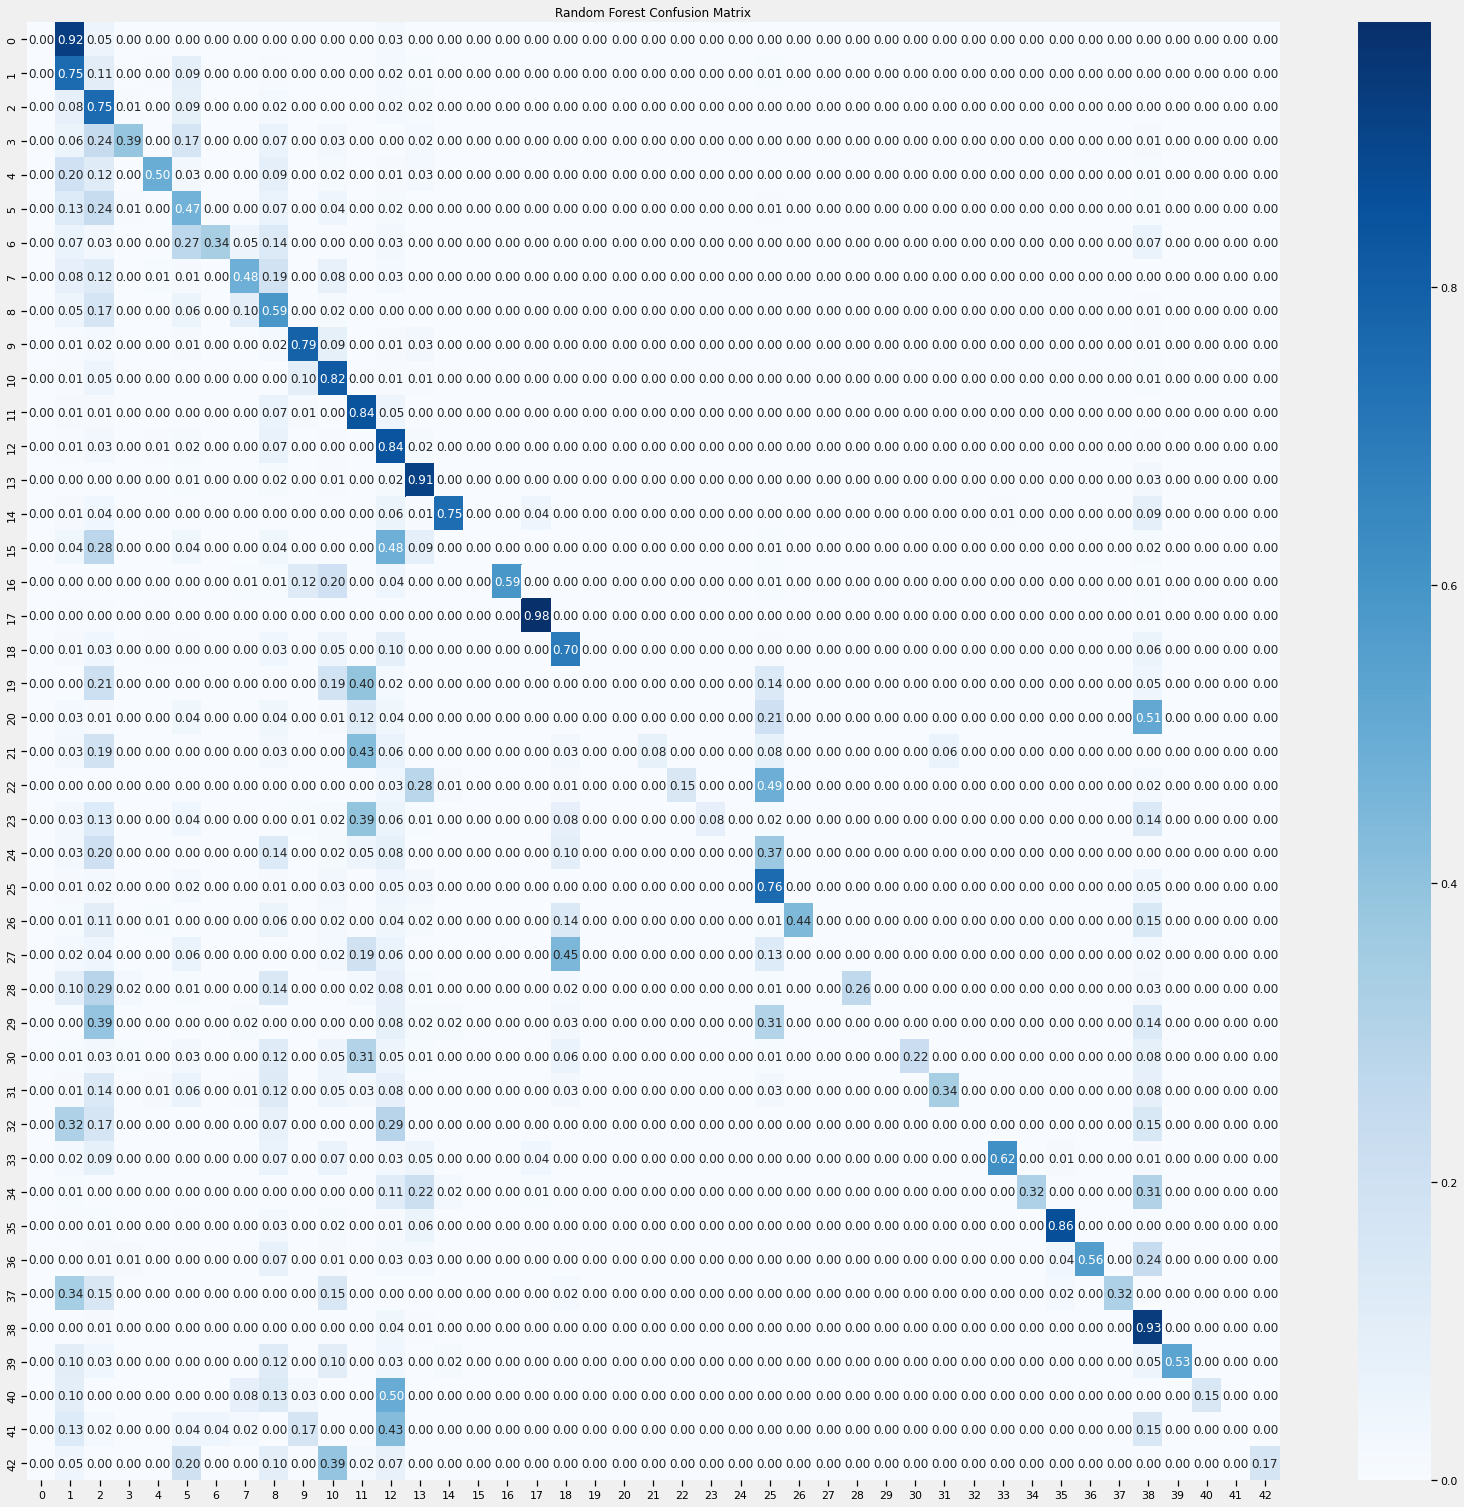

In [50]:
# Calculate predictions
import seaborn as sns
rf_predictions = loaded_rf_model.predict(X_test)
  
# creating a confusion matrix 
cm_rf = confusion_matrix(y_test, rf_predictions)
cm_rf = cm_rf.astype('float') / cm_rf.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(25,25))
sns.set_context("notebook")
sns.heatmap(cm_rf, annot = True, fmt='.2f', cmap="Blues").set_title("Random Forest Confusion Matrix")
plt.show()

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


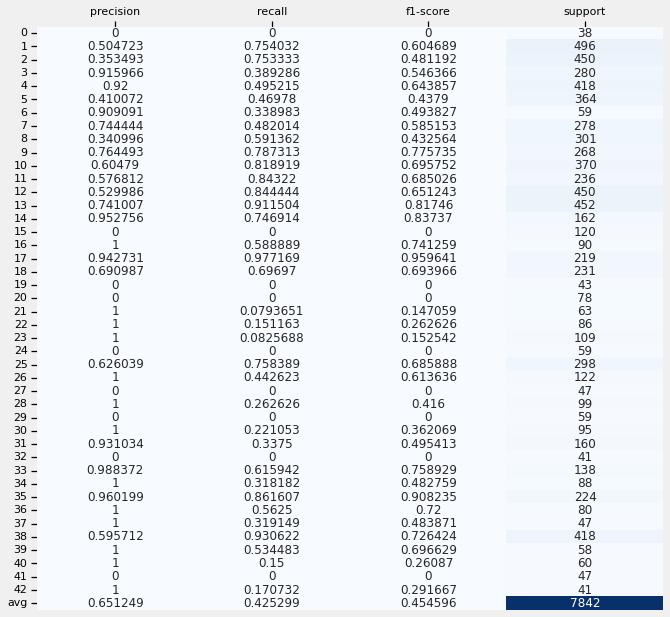

In [51]:
# utility function for plotting classification report
def plot_classification_report(y_tru, y_prd, figsize=(10, 10), ax=None):

    plt.figure(figsize=figsize)

    xticks = ['precision', 'recall', 'f1-score', 'support']
    yticks = list(np.unique(y_tru))
    yticks += ['avg']

    rep = np.array(precision_recall_fscore_support(y_tru, y_prd)).T
    avg = np.mean(rep, axis=0)
    avg[-1] = np.sum(rep[:, -1])
    rep = np.insert(rep, rep.shape[0], avg, axis=0)

    ax = sns.heatmap(rep,
                    annot=True, 
                    cbar=False, 
                    xticklabels=xticks, 
                    yticklabels=yticks,
                    ax=ax,
                    cmap="Blues",
                    fmt='g')
    ax.xaxis.set_ticks_position('top')


plot_classification_report(y_test, rf_predictions)

#### LightGBM

In [13]:
from sklearn.model_selection import RandomizedSearchCV
import lightgbm as lgb

param_grid = [
{'n_estimators': [10, 50, 100, 500], 
 'learning_rate': [0.0001, 0.001, 0.01, 0.1, 1.0],
 'subsample': [0.5, 0.7, 1.0],
 'max_depth': [3, 4, 5]} 
]

grid_search_lgb = RandomizedSearchCV(lgb.LGBMClassifier(), param_grid, cv=2, scoring='accuracy')
grid_search_lgb.fit(X_train, y_train.ravel())

RandomizedSearchCV(cv=2, estimator=LGBMClassifier(),
                   param_distributions=[{'learning_rate': [0.0001, 0.001, 0.01,
                                                           0.1, 1.0],
                                         'max_depth': [3, 4, 5],
                                         'n_estimators': [10, 50, 100, 500],
                                         'subsample': [0.5, 0.7, 1.0]}],
                   scoring='accuracy')

In [14]:
import joblib
joblib.dump(grid_search_lgb.best_estimator_, 'lightgbm_best_est.pkl')

['lightgbm_best_est.pkl']

In [16]:
loaded_lgb_model = joblib.load('lightgbm_best_est.pkl')
result = loaded_lgb_model.score(X_test, y_test)
print(f'Light GBM accuracy: {100*np.round(result, 2)}%')

Light GBM accuracy: 97.0%


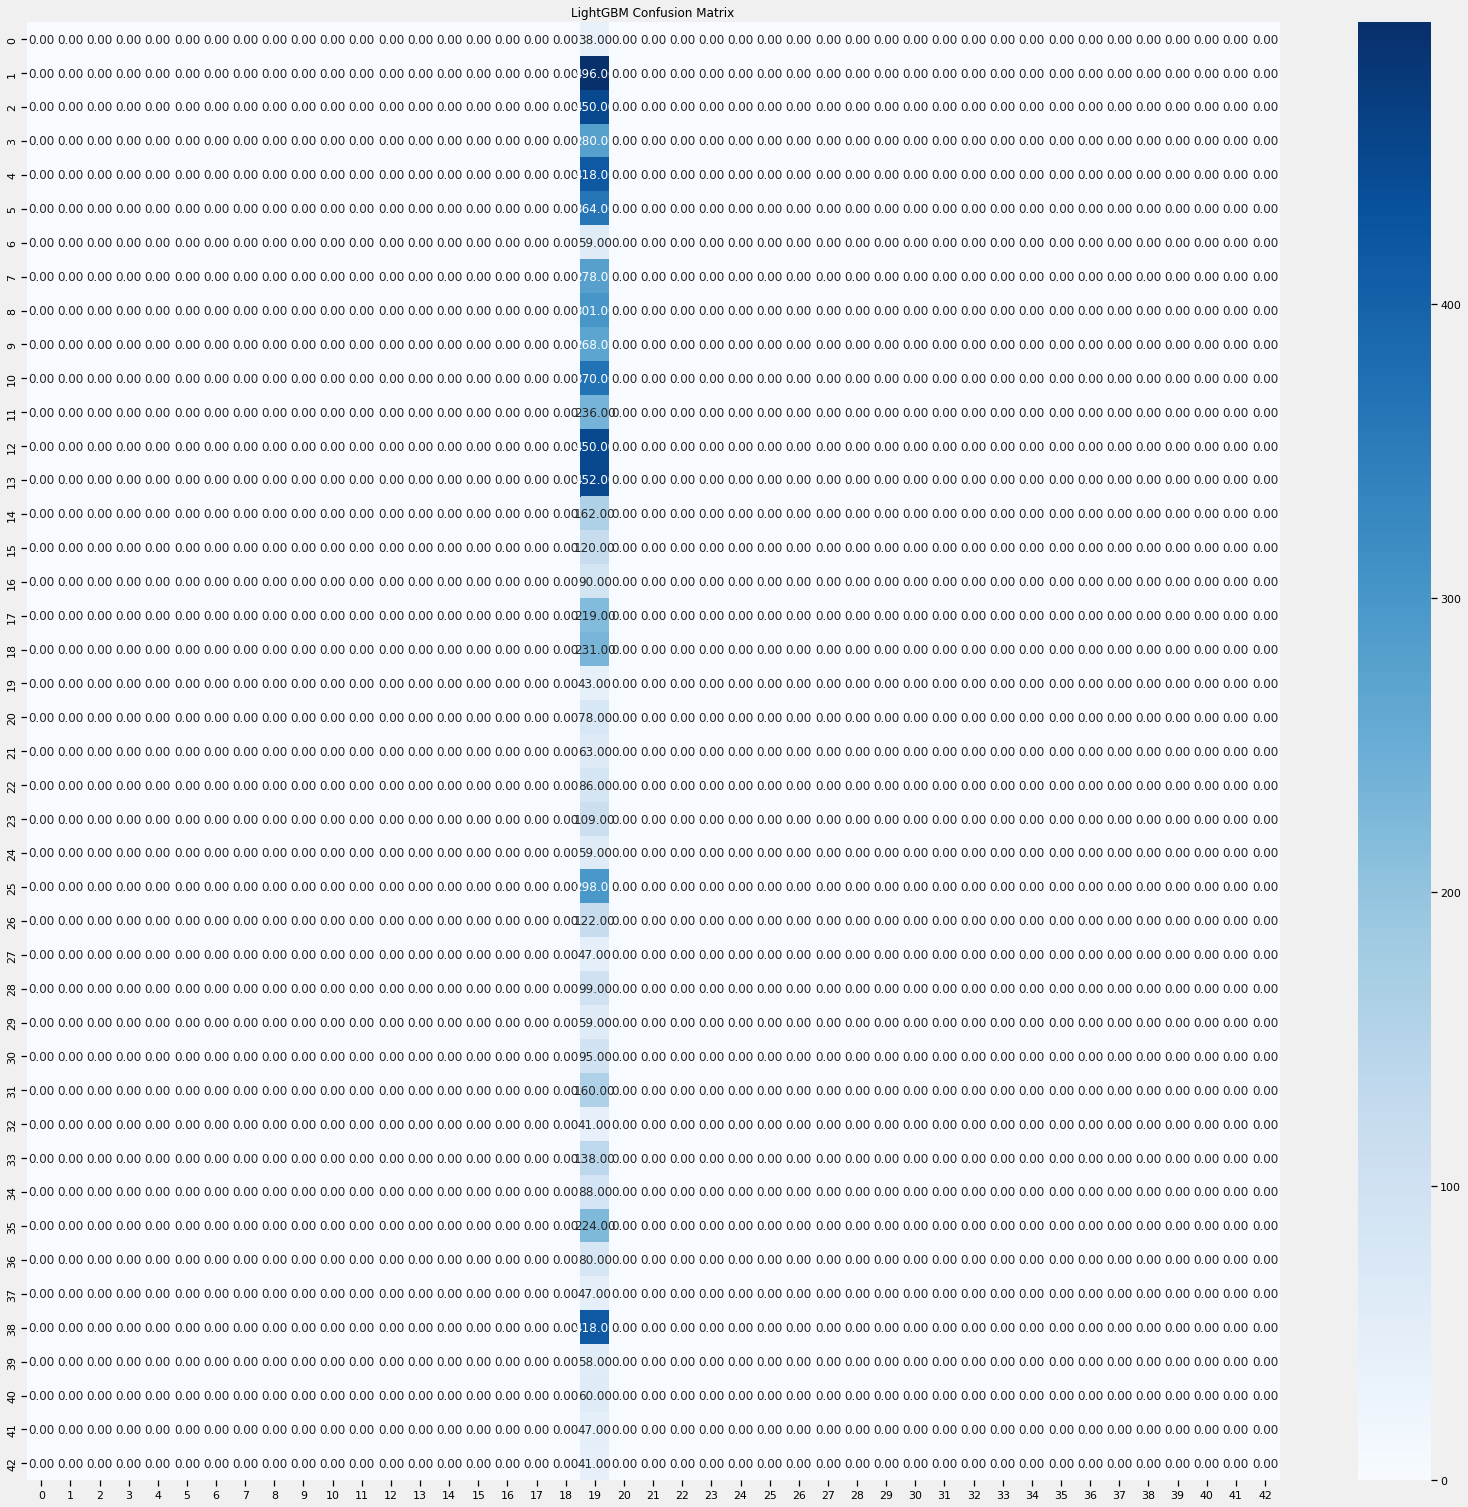

In [54]:
# Calculate predictions
import seaborn as sns
lgb_predictions = loaded_lgb_model.predict(X_test)
  
# creating a confusion matrix 
cm_lgb = confusion_matrix(y_test, lgb_predictions)

plt.figure(figsize=(25,25))
sns.set_context("notebook")
sns.heatmap(cm_lgb, annot = True, fmt='.2f', cmap="Blues").set_title("LightGBM Confusion Matrix")
plt.show()

## Neural Networks - CNN

In [56]:
# reshaping for cnn (keras requires input to be three-dimensional - in case of images with colours)

X_train = X_train.reshape(X_train.shape[0], 32, 32,1)
X_test = X_test.reshape(X_test.shape[0], 32, 32,1)

In [80]:
y_train.shape

(31367, 1)

In [81]:
from keras.models import Sequential, load_model
from keras.layers import Conv2D, Dense, Flatten, Rescaling, AveragePooling2D, Dropout
import time
from datetime import timedelta

start = time.time()
filters = [3, 5, 9, 13, 15]
models = {}

for key, value in enumerate(filters):


    print(f'Calculation of the model {key} with {value} filters has just started!')

    tmp_model = Sequential()
    tmp_model.add(Rescaling(1, input_shape=(32, 32, 1)))
    tmp_model.add(Conv2D(6, kernel_size=value, padding='same', activation='relu'))
    tmp_model.add(AveragePooling2D(pool_size=2))
    tmp_model.add(Dropout(0.2))
    tmp_model.add(Flatten())
    tmp_model.add(Dense(130, activation='relu'))
    tmp_model.add(Dense(43, activation='softmax'))
    tmp_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    print(f'Calculation of the model {key} with {value} filters has successfully finished!')
    print('-'*30)
    print('Something went wrong !')

    models[f'model_{key}'] = tmp_model

end = time.time()
print(f'Calculation time of models took {timedelta(minutes=end-start)}')

Calculation of the model 0 with 3 filters has just started!
Calculation of the model 0 with 3 filters has successfully finished!
------------------------------
Something went wrong !
Calculation of the model 1 with 5 filters has just started!
Calculation of the model 1 with 5 filters has successfully finished!
------------------------------
Something went wrong !
Calculation of the model 2 with 9 filters has just started!
Calculation of the model 2 with 9 filters has successfully finished!
------------------------------
Something went wrong !
Calculation of the model 3 with 13 filters has just started!
Calculation of the model 3 with 13 filters has successfully finished!
------------------------------
Something went wrong !
Calculation of the model 4 with 15 filters has just started!
Calculation of the model 4 with 15 filters has successfully finished!
------------------------------
Something went wrong !
Calculation time of models took 0:00:17.717957


In [66]:
models['model_0'].summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 32, 32, 1)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 6)         60        
                                                                 
 average_pooling2d_1 (Averag  (None, 16, 16, 6)        0         
 ePooling2D)                                                     
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 6)         0         
                                                                 
 flatten_1 (Flatten)         (None, 1536)              0         
                                                                 
 dense_2 (Dense)             (None, 130)               199810    
                                                      

In [ ]:
from keras.callbacks import EarlyStopping
import time
from datetime import timedelta

epochs = 50
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
history = {}
start = time.time()

for i in range(len(models)):
    # try:
    print(f'Model {i} is started being fitted!')
    print('')

    history[f'model_{i}_history'] = models[f'model_{i}'].fit(X_train, 
                                                              y_train,
                                                              epochs = epochs,
                                                              validation_data=(X_test, y_test),
                                                              callbacks = [callback],
                                                              verbose=0)
    
    print(f'''Model {i} has succesfully being fitted!
          Total number of epochs is equal to {len(history[f'model_{i}_history'].history['loss'])}
          The highest training accuracy is equal to {max(history[f'model_{i}_history'].history['accuracy'])}.
          The highest validation accuracy is equal to {max(history[f'model_{i}_history'].history['val_accuracy'])}.
          ''')
    print('-'*40)
    # except:
    print('Something went wrong')

end = time.time()
print(f'Calculation time of models took {timedelta(minutes=end-start)}')
    

Model 0 is started being fitted!

Model 0 has succesfully being fitted!
          Total number of epochs is equal to 10
          The highest training accuracy is equal to 0.9944527745246887.
          The highest validation accuracy is equal to 0.9824024438858032.
          
----------------------------------------
Something went wrong
Model 1 is started being fitted!

Model 1 has succesfully being fitted!
          Total number of epochs is equal to 31
          The highest training accuracy is equal to 0.9886505007743835.
          The highest validation accuracy is equal to 0.9817648530006409.
          
----------------------------------------
Something went wrong
Model 2 is started being fitted!

Model 2 has succesfully being fitted!
          Total number of epochs is equal to 45
          The highest training accuracy is equal to 0.9912009239196777.
          The highest validation accuracy is equal to 0.9859729409217834.
          
----------------------------------------
Some

In [75]:
from keras.models import Sequential, load_model
from keras.layers import Conv2D, Dense, Flatten, Rescaling, AveragePooling2D, Dropout

# Building the model
model = Sequential([
    Rescaling(1, input_shape=(32, 32, 1)),
    Conv2D(filters=6, kernel_size=(5, 5), activation='relu'),
    AveragePooling2D(pool_size=(2, 2)),
    Conv2D(filters=16, kernel_size=(5, 5), activation='relu'),
    AveragePooling2D(pool_size=(2, 2)),
    Conv2D(filters=120, kernel_size=(5, 5), activation='relu'),
    Dropout(0.2),
    Flatten(),
    Dense(units=120, activation='relu'),
    Dense(units=43, activation='softmax')
])

# Compilation of the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Model architecture
model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_12 (Rescaling)    (None, 32, 32, 1)         0         
                                                                 
 conv2d_11 (Conv2D)          (None, 28, 28, 6)         156       
                                                                 
 average_pooling2d_11 (Avera  (None, 14, 14, 6)        0         
 gePooling2D)                                                    
                                                                 
 conv2d_12 (Conv2D)          (None, 10, 10, 16)        2416      
                                                                 
 average_pooling2d_12 (Avera  (None, 5, 5, 16)         0         
 gePooling2D)                                                    
                                                                 
 conv2d_13 (Conv2D)          (None, 1, 1, 120)       

In [76]:
history = model.fit(X_train, y_train, epochs=50,
                    validation_data=(X_test, y_test))


Epoch 1/50


ValueError: ignored

In [ ]:
val_loss, val_acc = model.evaluate(X_test, y_test, verbose=2)
print('\nValifdation accuracy:', val_acc)
print('\nValidation loss:', val_loss)

246/246 - 6s - loss: 0.0466 - accuracy: 0.9904 - 6s/epoch - 24ms/step

Valifdation accuracy: 0.9904361367225647

Validation loss: 0.04658596217632294


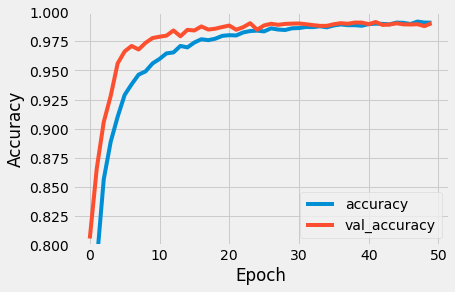

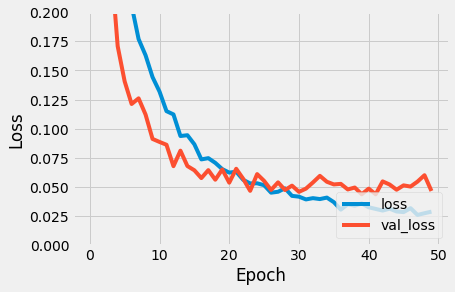

In [ ]:
plt.figure(0)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1])
plt.legend(loc='lower right')

plt.figure(1)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 0.2])
plt.legend(loc='lower right')

246/246 [==============================] - 3s 14ms/step


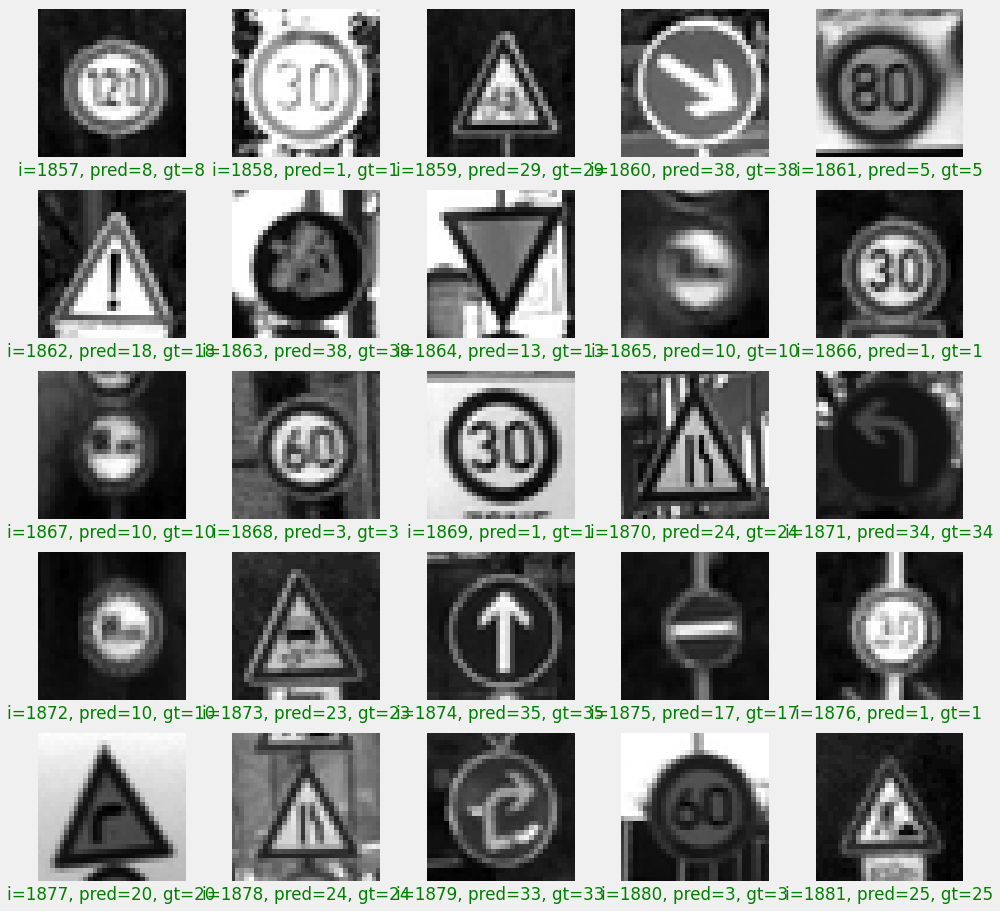

In [ ]:
import random
preds = model.predict(X_test)

plt.figure(figsize=(15, 15))
start_index = random.randint(0, 7800)
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    pred = np.argmax(preds[start_index+i])
    gt = np.argmax(y_test[start_index+i])
    
    col = 'g'
    if pred != gt:
        col = 'r'
    
    plt.xlabel('i={}, pred={}, gt={}'.format(start_index+i, pred, gt), color=col)
    plt.imshow(X_test[start_index+i].reshape((IMG_WIDTH, IMG_HEIGHT)), cmap='gray')
plt.show()